In [287]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.4. Gradient Boosting

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [289]:
X_train = pd.read_csv('../data/processed/SMOTE/X_train.csv')
y_train = pd.read_csv('../data/processed/SMOTE/y_train.csv')
X_val = pd.read_csv('../data/processed/SMOTE/X_val.csv')
y_val = pd.read_csv('../data/processed/SMOTE/y_val.csv')
X_test = pd.read_csv('../data/processed/SMOTE/X_test.csv')
y_test = pd.read_csv('../data/processed/SMOTE/y_test.csv')

In [290]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [291]:
from sklearn.ensemble import GradientBoostingClassifier

In [292]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [293]:
gb = GradientBoostingClassifier(random_state=8)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=8)

In [294]:
def gradient_boosting(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    gb_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Gradient Boosting'])
    
    return(gb_val)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.943969   0.987324  0.899487  0.941361  0.982602
Validation Set  0.898529   0.754717  0.416667  0.536913  0.815880


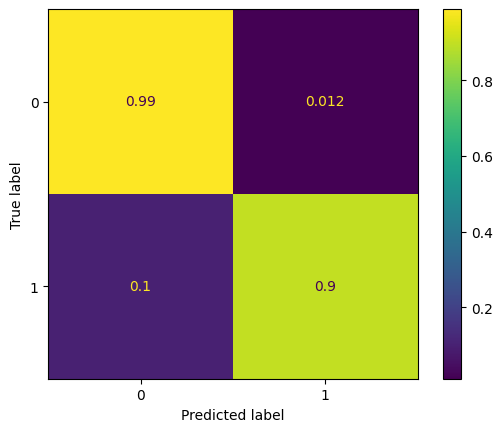

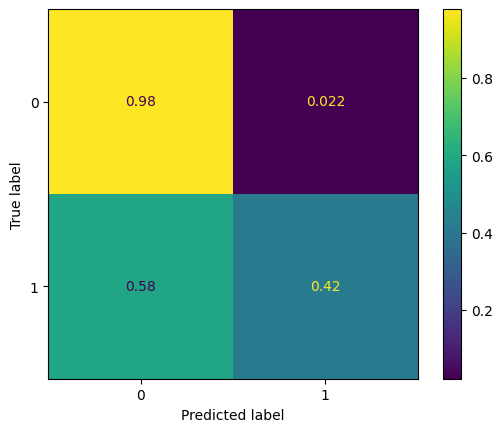

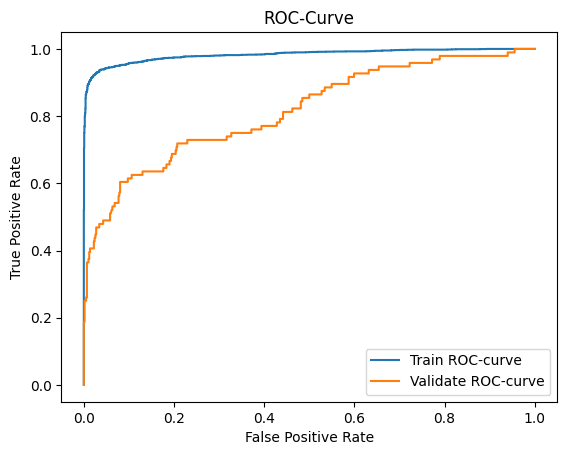

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.898529,0.754717,0.416667,0.536913,0.81588


In [205]:
gradient_boosting(gb)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with learning rate

default = 1

In [206]:
learning_rate = [0, 1, 2, 3, 5, 10, 20, 50, 100]

In [207]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in learning_rate:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_learning_rate = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=learning_rate)

tune_learning_rate

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0,0.500000,0.858824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
1,0.998503,0.892647,1.000000,0.649351,0.997006,0.520833,0.998501,0.578035,0.999994,0.781232
2,0.704448,0.654412,0.711692,0.160976,0.687340,0.343750,0.699304,0.219269,0.583562,0.455578
3,0.407186,0.155882,0.447912,0.132308,0.798118,0.895833,0.573801,0.230563,0.408577,0.466503
5,0.340462,0.198529,0.392321,0.118846,0.581266,0.729167,0.468459,0.204380,0.340462,0.420234
10,0.375749,0.141176,0.427175,0.116352,0.728828,0.770833,0.538644,0.202186,0.375749,0.404252
20,0.464927,0.713235,0.381844,0.045872,0.113345,0.052083,0.174802,0.048780,0.464927,0.437001
50,0.332335,0.154412,0.392779,0.114332,0.614200,0.739583,0.479146,0.198047,0.332335,0.398901
100,0.332335,0.154412,0.392779,0.114332,0.614200,0.739583,0.479146,0.198047,0.332335,0.398901


In [208]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_recall, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

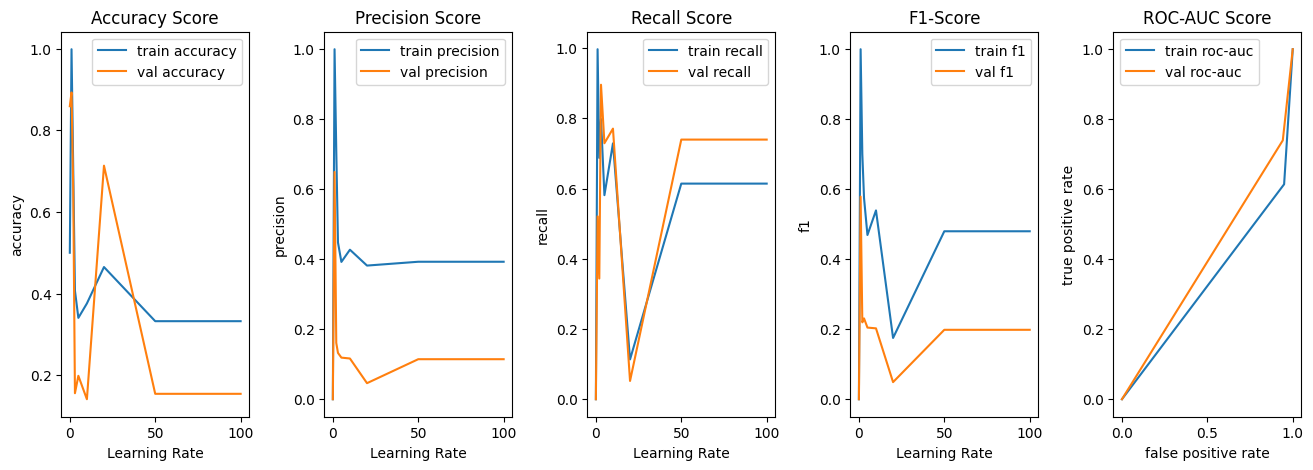

In [209]:
plot_performance(learning_rate, 'Learning Rate')

### Reduce Overfitting with n_estimators

default = None

In [210]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]

In [211]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
50,0.982036,0.877941,0.994298,0.589041,0.969632,0.447917,0.981810,0.508876,0.998062,0.770477
100,0.998503,0.892647,1.000000,0.649351,0.997006,0.520833,0.998501,0.578035,0.999994,0.781232
150,1.000000,0.891176,1.000000,0.652778,1.000000,0.489583,1.000000,0.559524,1.000000,0.779841
200,1.000000,0.894118,1.000000,0.666667,1.000000,0.500000,1.000000,0.571429,1.000000,0.790472
250,1.000000,0.889706,1.000000,0.643836,1.000000,0.489583,1.000000,0.556213,1.000000,0.802173
300,1.000000,0.900000,1.000000,0.718750,1.000000,0.479167,1.000000,0.575000,1.000000,0.801370
350,1.000000,0.901471,1.000000,0.730159,1.000000,0.479167,1.000000,0.578616,1.000000,0.797981
400,1.000000,0.907353,1.000000,0.753846,1.000000,0.510417,1.000000,0.608696,1.000000,0.803189
450,1.000000,0.902941,1.000000,0.750000,1.000000,0.468750,1.000000,0.576923,1.000000,0.807934
500,1.000000,0.908824,1.000000,0.793103,1.000000,0.479167,1.000000,0.597403,1.000000,0.809807


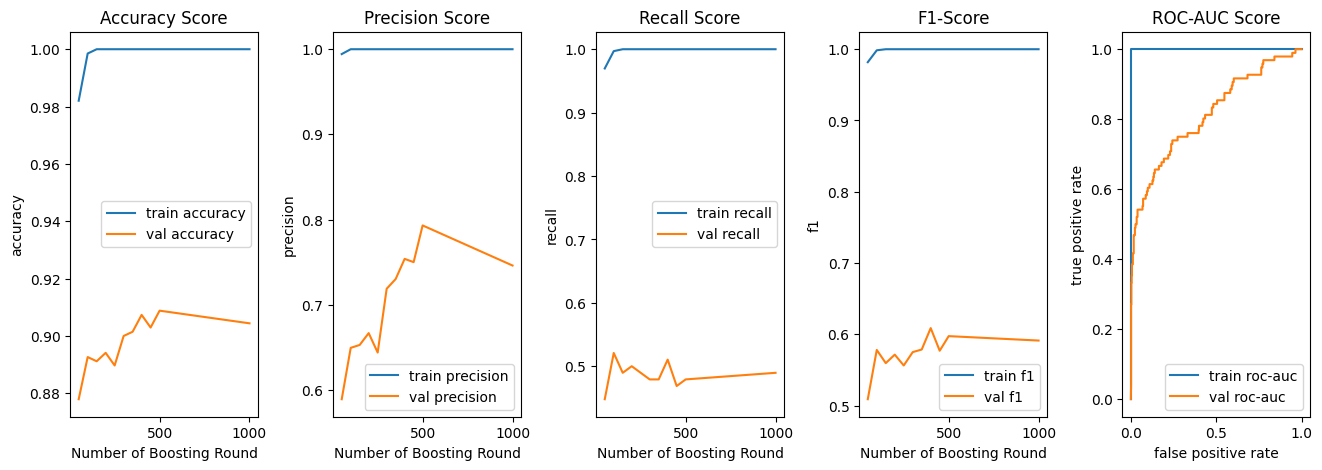

In [212]:
plot_performance(n_estimators, 'Number of Boosting Round')

#### n_estimators = 400

In [213]:
gb_n_estimators = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400)
gb_n_estimators.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.907353   0.753846  0.510417  0.608696  0.803189


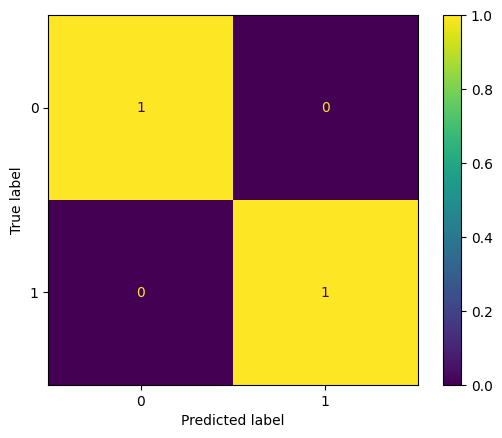

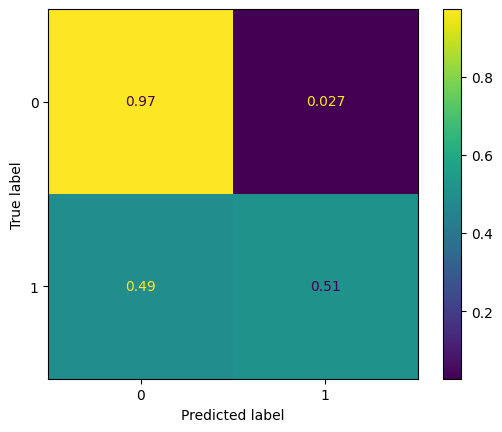

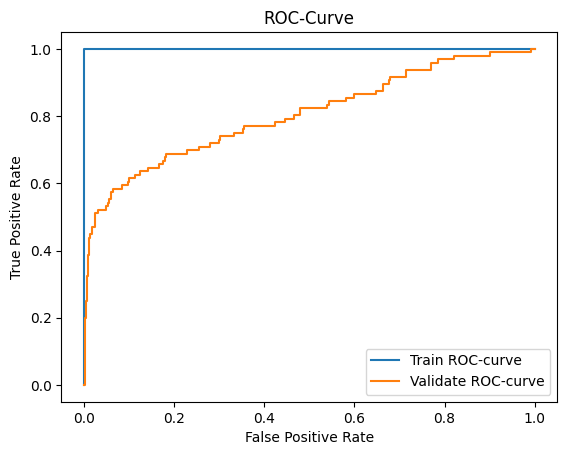

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.907353,0.753846,0.510417,0.608696,0.803189


In [214]:
gradient_boosting(gb_n_estimators)

### Reduce Overfitting with max depth

default = 2

In [215]:
max_depth = np.arange(3, 21)

In [216]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
3,1.0,0.907353,1.0,0.753846,1.0,0.510417,1.0,0.608696,1.0,0.803189
4,1.0,0.905882,1.0,0.766667,1.0,0.479167,1.0,0.589744,1.0,0.801655
5,1.0,0.901471,1.0,0.754386,1.0,0.447917,1.0,0.562092,1.0,0.816513
6,1.0,0.908824,1.0,0.793103,1.0,0.479167,1.0,0.597403,1.0,0.823202
7,1.0,0.908824,1.0,0.840000,1.0,0.437500,1.0,0.575342,1.0,0.796286
8,1.0,0.914706,1.0,0.880000,1.0,0.458333,1.0,0.602740,1.0,0.794253
9,1.0,0.910294,1.0,0.830189,1.0,0.458333,1.0,0.590604,1.0,0.798730
10,1.0,0.908824,1.0,0.814815,1.0,0.458333,1.0,0.586667,1.0,0.806507
11,1.0,0.910294,1.0,0.843137,1.0,0.447917,1.0,0.585034,1.0,0.810467
12,1.0,0.902941,1.0,0.800000,1.0,0.416667,1.0,0.547945,1.0,0.785584


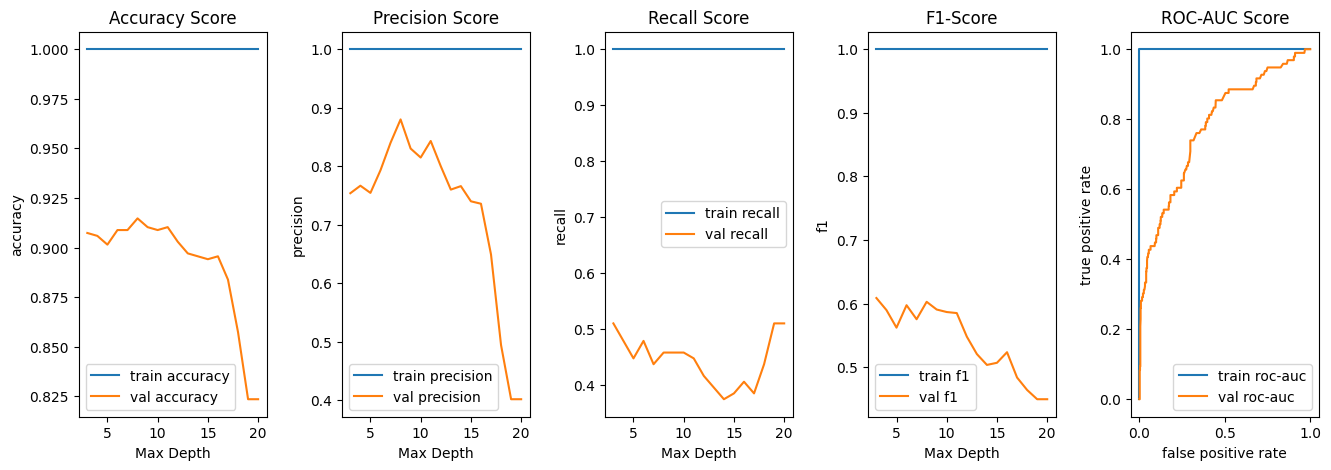

In [217]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 3

In [218]:
gb_max_depth = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3)
gb_max_depth.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.907353   0.753846  0.510417  0.608696  0.803189


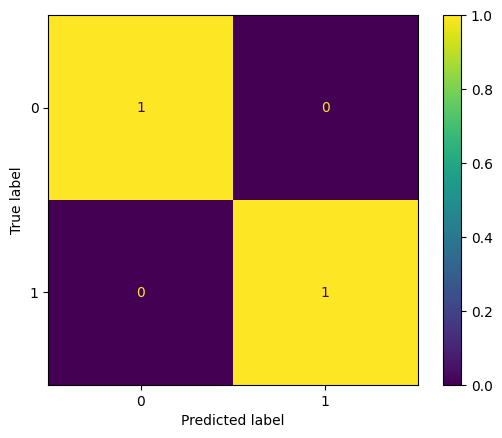

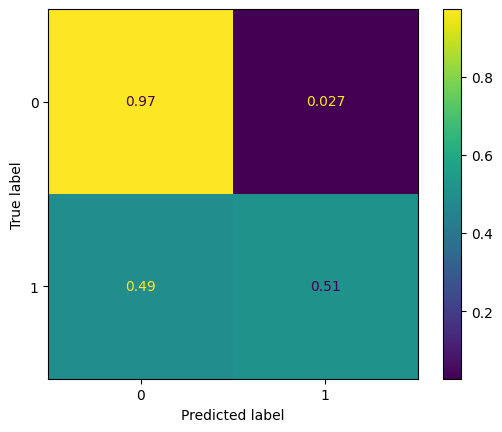

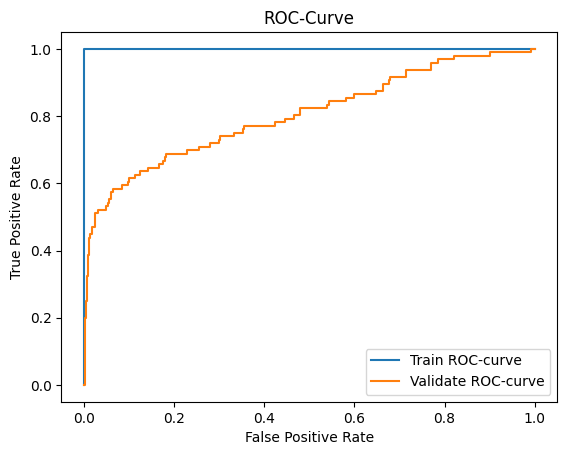

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.907353,0.753846,0.510417,0.608696,0.803189


In [219]:
gradient_boosting(gb_max_depth)

### Reduce Overfitting with sub sample

default = 1

In [220]:
subsample = np.arange(0.1, 1.1, 0.1)

In [221]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in subsample:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_subsample = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=subsample)

tune_subsample

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.1,0.394568,0.164706,0.436616,0.120579,0.726262,0.781250,0.545367,0.208914,0.394568,0.422303
0.2,0.593242,0.647059,0.611680,0.184211,0.510693,0.437500,0.556643,0.259259,0.593242,0.559503
0.3,0.892643,0.798529,0.876847,0.356643,0.913601,0.531250,0.894847,0.426778,0.886194,0.708735
0.4,0.945252,0.863235,0.956179,0.518987,0.933276,0.427083,0.944589,0.468571,0.972212,0.742794
0.5,0.946536,0.861765,0.961947,0.512195,0.929855,0.437500,0.945629,0.471910,0.976246,0.775703
0.6,0.970274,0.820588,0.976593,0.383929,0.963644,0.447917,0.970075,0.413462,0.982394,0.747155
0.7,0.973695,0.860294,0.984259,0.505495,0.962789,0.479167,0.973405,0.491979,0.993152,0.754816
0.8,0.999786,0.883824,1.000000,0.616438,0.999572,0.468750,0.999786,0.532544,0.999574,0.771065
0.9,1.000000,0.885294,1.000000,0.625000,1.000000,0.468750,1.000000,0.535714,1.000000,0.825717
1.0,1.000000,0.907353,1.000000,0.753846,1.000000,0.510417,1.000000,0.608696,1.000000,0.803189


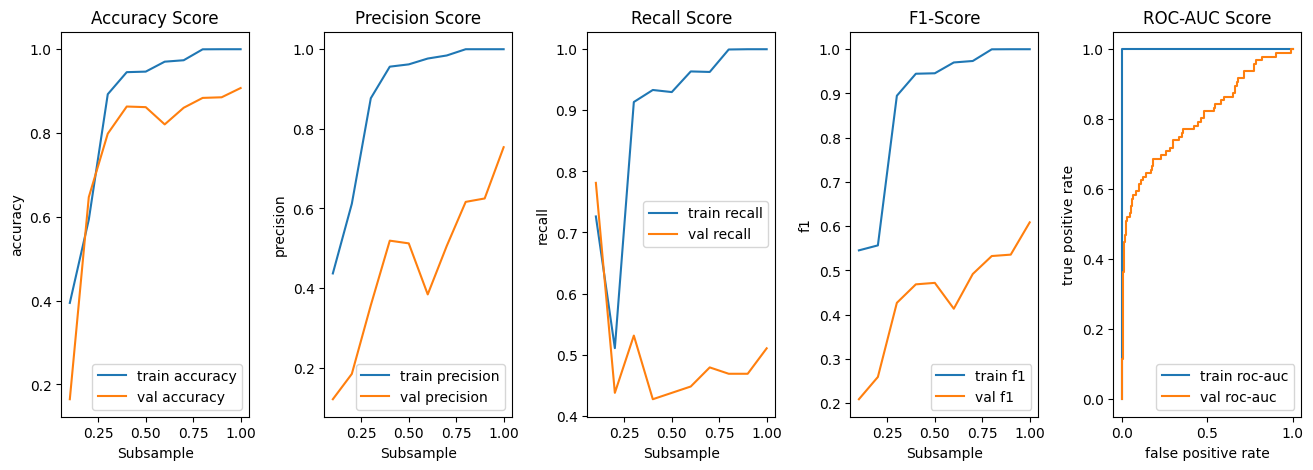

In [222]:
plot_performance(subsample, 'Subsample')

### Reduce Overfitting with Loss Function

default = log_loss

In [223]:
loss = ['log_loss', 'exponential']

In [224]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in loss:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_loss = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=loss)

tune_loss

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
log_loss,1.0,0.907353,1.0,0.753846,1.0,0.510417,1.0,0.608696,1.0,0.803189
exponential,1.0,0.911765,1.0,0.790323,1.0,0.510417,1.0,0.620253,1.0,0.828357


### Reduce Overfitting with Min Samples per Leaf

default = 1

In [225]:
min_samples_leaf = [1, 2, 5, 10, 20, 30, 50, 60, 70, 80, 90,100]

In [226]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,1.0,0.911765,1.0,0.790323,1.0,0.510417,1.0,0.620253,1.0,0.828357
2,1.0,0.904412,1.0,0.762712,1.0,0.468750,1.0,0.580645,1.0,0.827465
5,1.0,0.904412,1.0,0.754098,1.0,0.479167,1.0,0.585987,1.0,0.827733
10,1.0,0.898529,1.0,0.728814,1.0,0.447917,1.0,0.554839,1.0,0.821579
20,1.0,0.905882,1.0,0.742424,1.0,0.510417,1.0,0.604938,1.0,0.807862
30,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
50,1.0,0.904412,1.0,0.718310,1.0,0.531250,1.0,0.610778,1.0,0.818440
60,1.0,0.902941,1.0,0.734375,1.0,0.489583,1.0,0.587500,1.0,0.813606
70,1.0,0.900000,1.0,0.712121,1.0,0.489583,1.0,0.580247,1.0,0.803867
80,1.0,0.901471,1.0,0.716418,1.0,0.500000,1.0,0.588957,1.0,0.830747


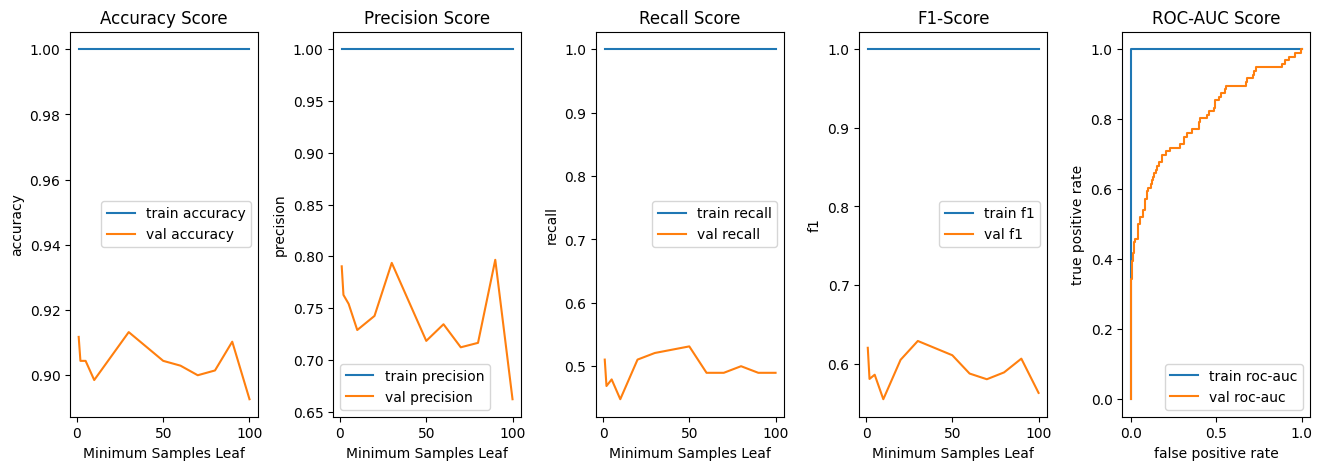

In [227]:
plot_performance(min_samples_leaf, 'Minimum Samples Leaf')

#### min_samples_leaf = 30

In [228]:
gb_min_samples_leaf = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=30)
gb_min_samples_leaf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, loss='exponential',
                           min_samples_leaf=30, n_estimators=400,
                           random_state=8, subsample=1)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.913235   0.793651  0.520833  0.628931  0.827822


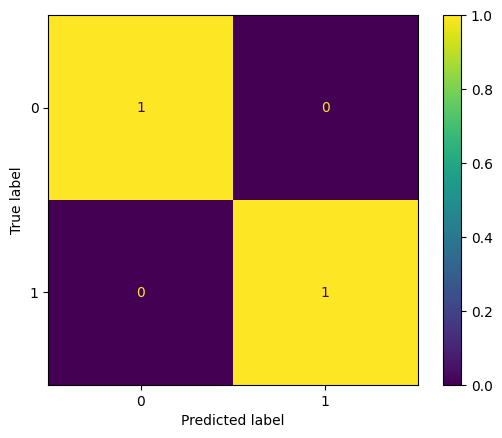

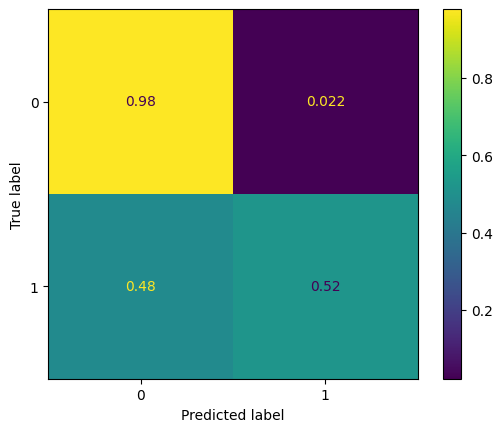

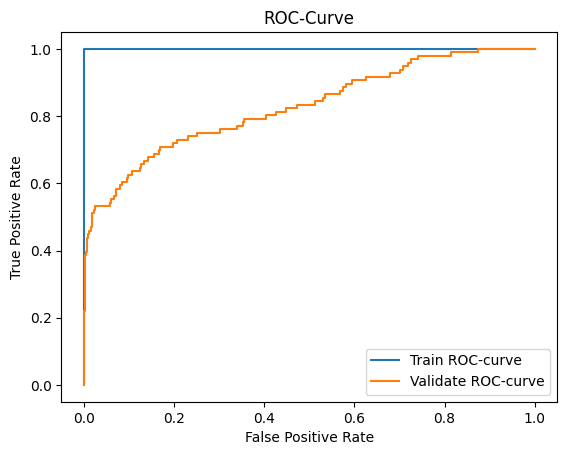

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.913235,0.793651,0.520833,0.628931,0.827822


In [229]:
gradient_boosting(gb_min_samples_leaf)

### Reduce Overfitting with Min Samples Split

default = 2

In [230]:
min_samples_split = [2, 3, 5, 10, 20, 50, 60, 70, 80, 90, 100]

In [231]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=30, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
3,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
5,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
10,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
20,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
50,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
60,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822
70,1.0,0.911765,1.0,0.781250,1.0,0.520833,1.0,0.625000,1.0,0.811840
80,1.0,0.901471,1.0,0.716418,1.0,0.500000,1.0,0.588957,1.0,0.809932
90,1.0,0.895588,1.0,0.698413,1.0,0.458333,1.0,0.553459,1.0,0.806864


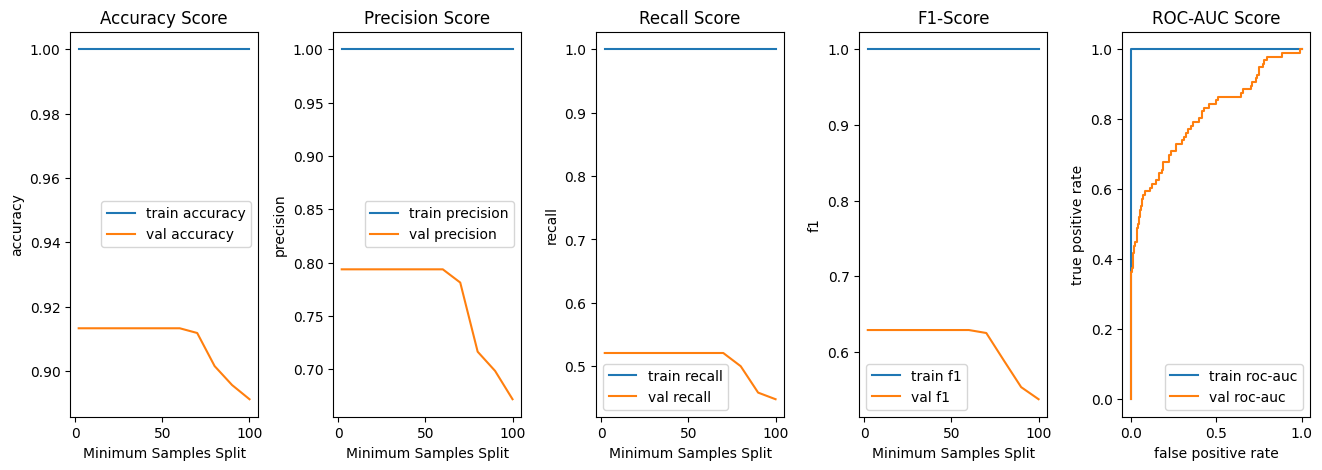

In [232]:
plot_performance(min_samples_split, 'Minimum Samples Split')

#### min_samples_split = 2

In [233]:
gb_min_samples_leaf = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=30, min_samples_split=2)
gb_min_samples_leaf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, loss='exponential',
                           min_samples_leaf=30, n_estimators=400,
                           random_state=8, subsample=1)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.913235   0.793651  0.520833  0.628931  0.827822


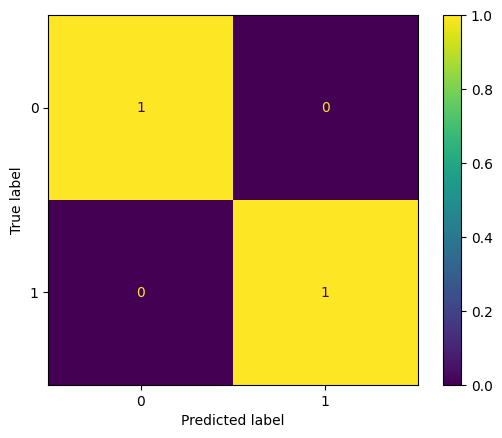

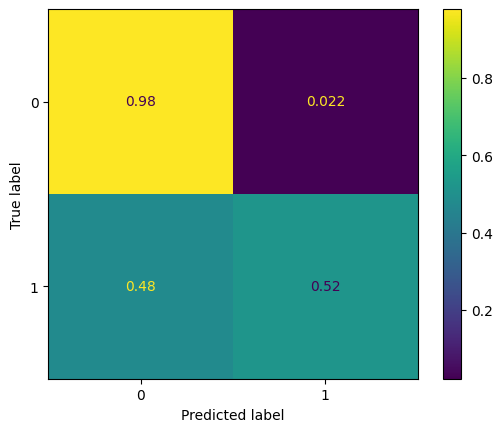

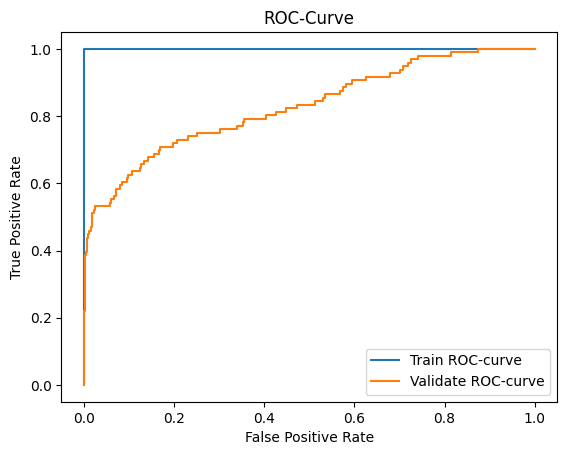

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.913235,0.793651,0.520833,0.628931,0.827822


In [234]:
gradient_boosting(gb_min_samples_leaf)

### Reduce overfitting with Max Features

In [235]:
max_features = ['sqrt', 'log2', None]

In [236]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=30, min_samples_split=2, max_features=i).fit(X_train, y_train)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
sqrt,1.0,0.897059,1.0,0.709677,1.0,0.458333,1.0,0.556962,1.0,0.798195
log2,1.0,0.894118,1.0,0.693548,1.0,0.447917,1.0,0.544304,1.0,0.799140
None,1.0,0.913235,1.0,0.793651,1.0,0.520833,1.0,0.628931,1.0,0.827822


### Model After Hyperparameter Tuning

In [237]:
from sklearn.metrics import precision_recall_curve

In [238]:
gb_tune = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=400, max_depth=3, subsample=1, loss='exponential', min_samples_leaf=30, min_samples_split=2, max_features=None)
gb_tune.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, loss='exponential',
                           min_samples_leaf=30, n_estimators=400,
                           random_state=8, subsample=1)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.913235   0.793651  0.520833  0.628931  0.827822


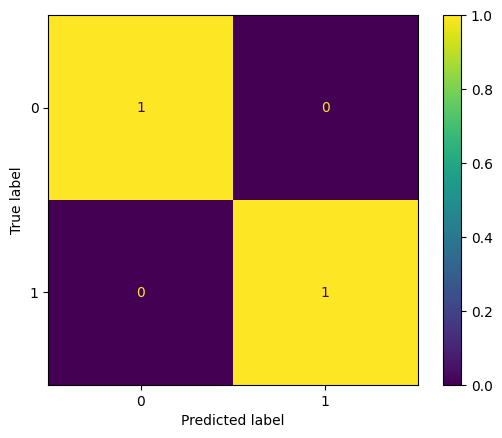

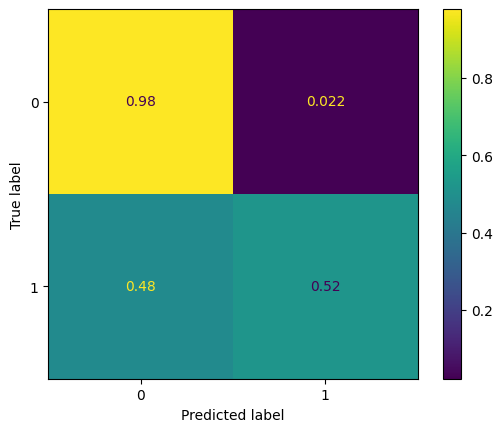

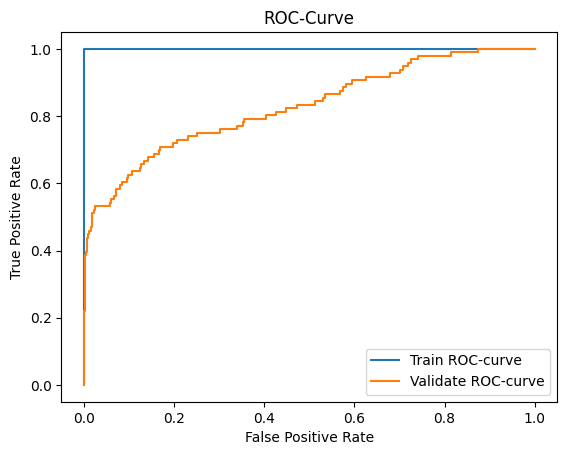

In [239]:
gb_smote = gradient_boosting(gb_tune)

In [240]:
dump(gb, '../models/gradient_boosting_smote.joblib')

['../models/gradient_boosting_smote.joblib']

### Adjust the threshold

In [241]:
def adjust_threshold(model):
    thresholds = np.arange(0.1, 1, 0.1)
    
    all_thresholds = []
    
    for threshold in thresholds:
        y_train_probs = model.predict_proba(X_train)[:, 1]
        y_val_probs = model.predict_proba(X_val)[:, 1]
    
        y_train_preds = (y_train_probs >= threshold).astype(int)
        y_val_preds = (y_val_probs >= threshold).astype(int)
    
        train_accuracy = accuracy_score(y_train, y_train_preds)
        train_precision = precision_score(y_train, y_train_preds)
        train_recall = recall_score(y_train, y_train_preds)
        train_f1 = f1_score(y_train, y_train_preds)
        train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
        val_accuracy = accuracy_score(y_val, y_val_preds)
        val_precision = precision_score(y_val, y_val_preds)
        val_recall = recall_score(y_val, y_val_preds)
        val_f1 = f1_score(y_val, y_val_preds)
        val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
        train_score = pd.DataFrame({
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1-score': train_f1,
            'roc-auc': train_roc_auc}, index=[f'Threshold = {threshold:.1f} - Training Set'])
    
        val_score = pd.DataFrame({
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1-score': val_f1,
            'roc-auc': val_roc_auc}, index=[f'Threshold = {threshold:.1f} - Validation Set'])

        score = pd.concat([train_score, val_score])
        all_thresholds.append(score)
        
    return pd.concat(all_thresholds)

In [242]:
adjust_threshold(gb_tune)

,accuracy,precision,recall,f1-score,roc-auc
Threshold = 0.1 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.1 - Validation Set,0.897059,0.671053,0.531250,0.593023,0.827822
Threshold = 0.2 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.2 - Validation Set,0.902941,0.708333,0.531250,0.607143,0.827822
Threshold = 0.3 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.3 - Validation Set,0.907353,0.739130,0.531250,0.618182,0.827822
Threshold = 0.4 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.4 - Validation Set,0.911765,0.772727,0.531250,0.629630,0.827822
Threshold = 0.5 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.5 - Validation Set,0.913235,0.793651,0.520833,0.628931,0.827822


Adjusting the threshold is not leading to incrase a recall at all. The recall ranges between 0.52 - 0.53 across different thresholds.

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [243]:
gb_smote.to_csv('../data/processed/model/5_gb_smote.csv', index=False)

### Without SMOTE (use class_weight = 'balanced')

In [244]:
from sklearn.utils.class_weight import compute_sample_weight

In [245]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [246]:
y_train.value_counts(normalize=True)

churn
0        0.859559
1        0.140441
Name: proportion, dtype: float64

In [247]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [248]:
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [249]:
gb = GradientBoostingClassifier(random_state=8)
gb.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.926471   0.699561  0.835079  0.761337  0.963765
Validation Set  0.876471   0.565217  0.541667  0.553191  0.825895


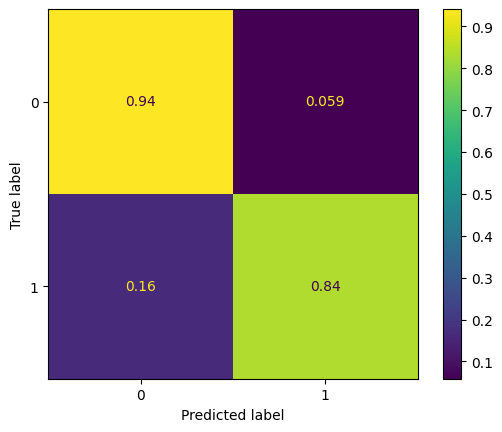

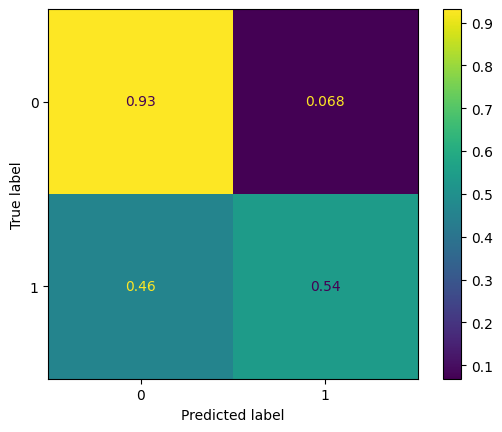

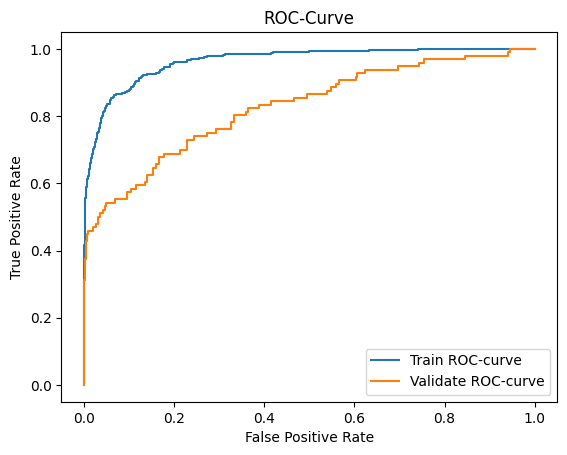

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.876471,0.565217,0.541667,0.553191,0.825895


In [251]:
gradient_boosting(gb)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with learning rate

default = 1

In [252]:
learning_rate = [0, 1, 2, 3, 5, 10, 20, 50, 100]

In [253]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in learning_rate:
    gb = GradientBoostingClassifier(random_state=8,learning_rate=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_learning_rate = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=learning_rate)

tune_learning_rate

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0,0.140441,0.141176,0.140441,0.141176,1.000000,1.000000,0.246293,0.247423,0.500000,0.500000
1,0.999632,0.892647,0.997389,0.638554,1.000000,0.552083,0.998693,0.592179,1.000000,0.819296
2,0.505882,0.475000,0.108306,0.121739,0.348168,0.437500,0.165217,0.190476,0.441024,0.459225
3,0.124632,0.147059,0.098433,0.113419,0.641361,0.739583,0.170672,0.196676,0.340783,0.394620
5,0.886029,0.888235,0.986486,1.000000,0.191099,0.208333,0.320175,0.344828,0.595336,0.604167
10,0.152206,0.175000,0.095458,0.115702,0.594241,0.729167,0.164493,0.199715,0.337112,0.406535
20,0.176838,0.191176,0.098920,0.116554,0.599476,0.718750,0.169818,0.200581,0.353630,0.411601
50,0.199632,0.210294,0.100579,0.117851,0.591623,0.708333,0.171928,0.202080,0.363605,0.418379
100,0.153676,0.169118,0.105588,0.121163,0.672775,0.781250,0.182528,0.209790,0.370819,0.424872


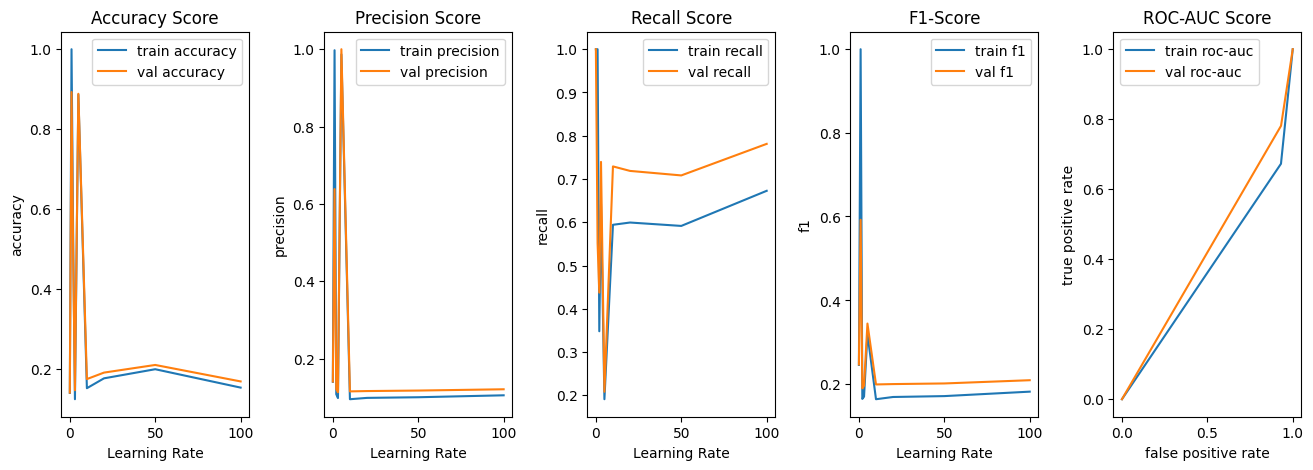

In [254]:
plot_performance(learning_rate, 'Learning Rate')

### Reduce Overfitting with n_estimators

default = None

In [255]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 1000]

In [256]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
50,0.979779,0.877941,0.874142,0.567010,1.0,0.572917,0.932845,0.569948,0.998634,0.801566
100,0.999632,0.892647,0.997389,0.638554,1.0,0.552083,0.998693,0.592179,1.000000,0.819296
150,1.000000,0.898529,1.000000,0.675325,1.0,0.541667,1.000000,0.601156,1.000000,0.821757
200,1.000000,0.904412,1.000000,0.706667,1.0,0.552083,1.000000,0.619883,1.000000,0.821472
250,1.000000,0.911765,1.000000,0.764706,1.0,0.541667,1.000000,0.634146,1.000000,0.829053
300,1.000000,0.914706,1.000000,0.779412,1.0,0.552083,1.000000,0.646341,1.000000,0.831015
350,1.000000,0.911765,1.000000,0.764706,1.0,0.541667,1.000000,0.634146,1.000000,0.828482
400,1.000000,0.913235,1.000000,0.768116,1.0,0.552083,1.000000,0.642424,1.000000,0.828303
450,1.000000,0.914706,1.000000,0.779412,1.0,0.552083,1.000000,0.646341,1.000000,0.837489
500,1.000000,0.916176,1.000000,0.782609,1.0,0.562500,1.000000,0.654545,1.000000,0.836116


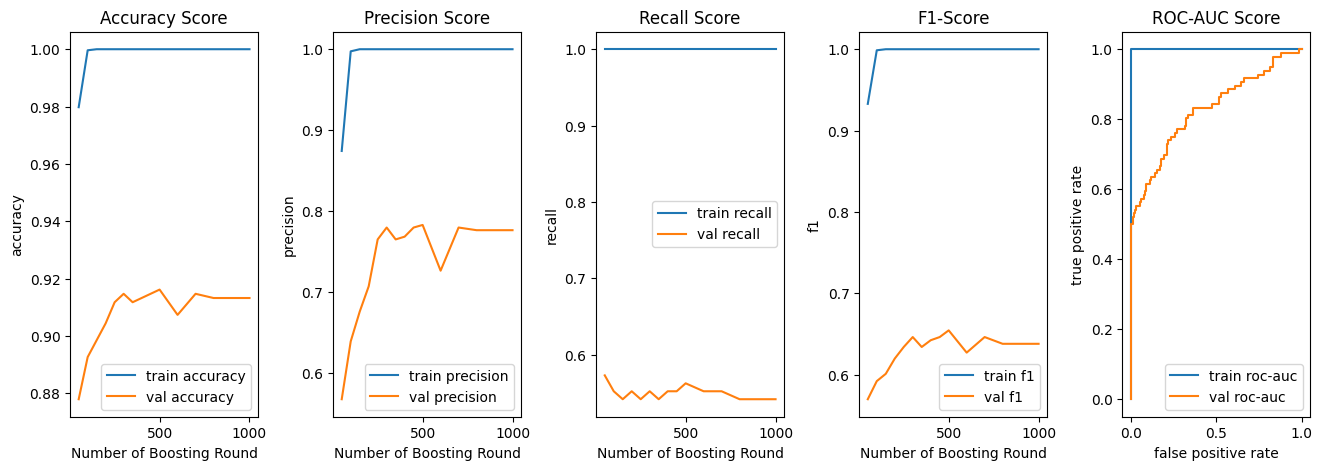

In [257]:
plot_performance(n_estimators, 'Number of Boosting Round')

#### n_estimators = 500

In [258]:
gb_n_estimators = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500)
gb_n_estimators.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_state=8)

                accuracy  precision  recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.0000  1.000000  1.000000
Validation Set  0.916176   0.782609  0.5625  0.654545  0.836116


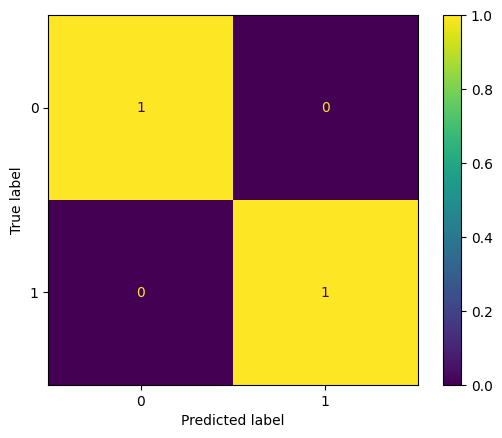

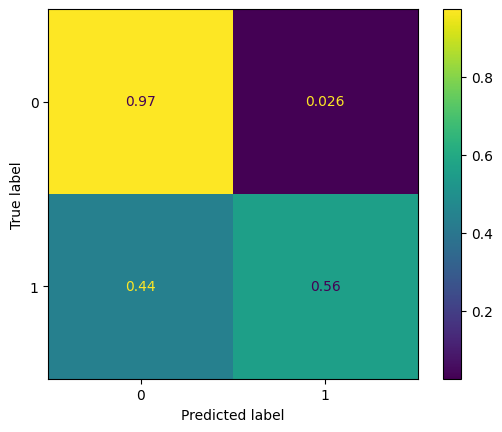

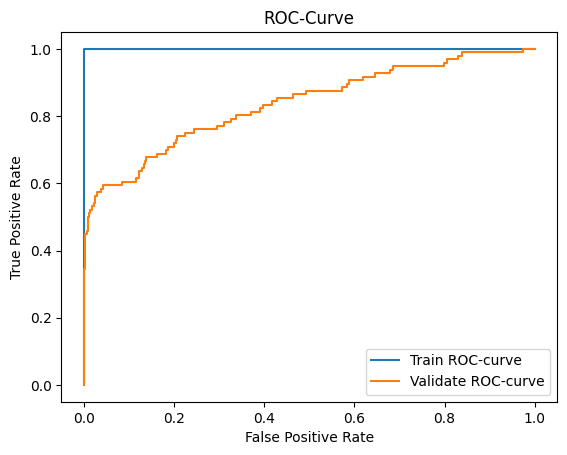

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.916176,0.782609,0.5625,0.654545,0.836116


In [259]:
gradient_boosting(gb_n_estimators)

### Reduce Overfitting with max depth

default = 2

In [260]:
max_depth = np.arange(3, 21)

In [261]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
3,1.0,0.916176,1.0,0.782609,1.0,0.562500,1.0,0.654545,1.0,0.836116
4,1.0,0.920588,1.0,0.875000,1.0,0.510417,1.0,0.644737,1.0,0.814908
5,1.0,0.911765,1.0,0.800000,1.0,0.500000,1.0,0.615385,1.0,0.824861
6,1.0,0.922059,1.0,0.921569,1.0,0.489583,1.0,0.639456,1.0,0.803582
7,1.0,0.922059,1.0,0.905660,1.0,0.500000,1.0,0.644295,1.0,0.804580
8,1.0,0.920588,1.0,0.937500,1.0,0.468750,1.0,0.625000,1.0,0.841966
9,1.0,0.922059,1.0,0.921569,1.0,0.489583,1.0,0.639456,1.0,0.804010
10,1.0,0.917647,1.0,0.916667,1.0,0.458333,1.0,0.611111,1.0,0.792202
11,1.0,0.916176,1.0,0.914894,1.0,0.447917,1.0,0.601399,1.0,0.812946
12,1.0,0.917647,1.0,0.934783,1.0,0.447917,1.0,0.605634,1.0,0.773473


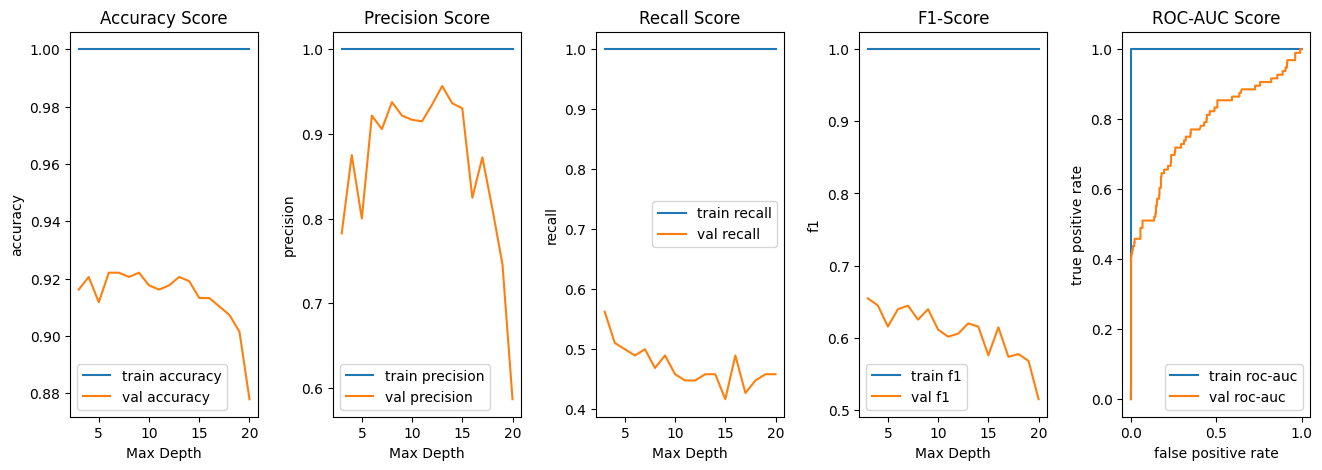

In [262]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 3

In [263]:
gb_max_depth = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3)
gb_max_depth.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_state=8)

                accuracy  precision  recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.0000  1.000000  1.000000
Validation Set  0.916176   0.782609  0.5625  0.654545  0.836116


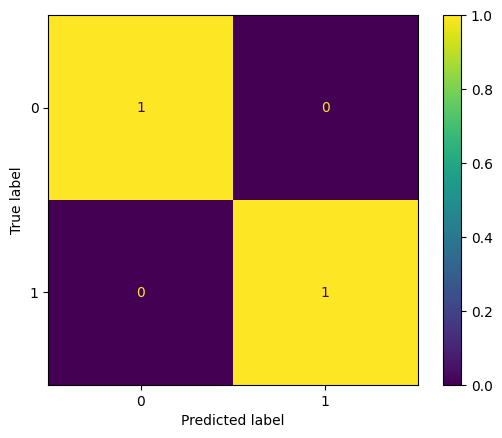

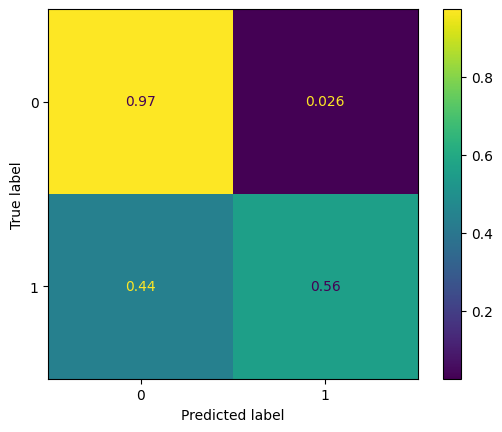

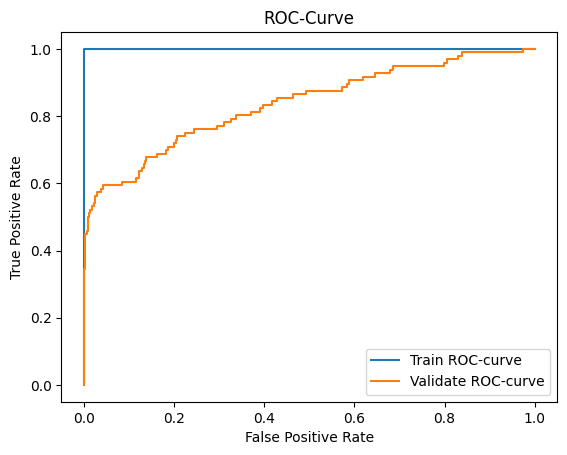

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.916176,0.782609,0.5625,0.654545,0.836116


In [264]:
gradient_boosting(gb_max_depth)

### Reduce Overfitting with sub sample

default = 1

In [265]:
subsample = np.arange(0.1, 1.1, 0.1)

In [266]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in subsample:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_subsample = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=subsample)

tune_subsample

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.1,0.540809,0.545588,0.148418,0.166144,0.479058,0.552083,0.226625,0.255422,0.514978,0.548302
0.2,0.398897,0.392647,0.116350,0.114355,0.497382,0.489583,0.188586,0.185404,0.440094,0.434682
0.3,0.558824,0.557353,0.157454,0.142857,0.492147,0.427083,0.238579,0.214099,0.530932,0.502925
0.4,0.795221,0.775000,0.290168,0.264463,0.316754,0.333333,0.302879,0.294931,0.595075,0.590468
0.5,0.901103,0.801471,0.598604,0.359712,0.897906,0.520833,0.718325,0.425532,0.938094,0.754611
0.6,0.991912,0.860294,0.966321,0.505495,0.976440,0.479167,0.971354,0.491979,0.971636,0.720552
0.7,0.975000,0.845588,0.856818,0.459459,0.986911,0.531250,0.917275,0.492754,0.970214,0.751873
0.8,1.000000,0.895588,1.000000,0.686567,1.000000,0.479167,1.000000,0.564417,1.000000,0.817583
0.9,1.000000,0.888235,1.000000,0.628205,1.000000,0.510417,1.000000,0.563218,1.000000,0.798605
1.0,1.000000,0.916176,1.000000,0.782609,1.000000,0.562500,1.000000,0.654545,1.000000,0.836116


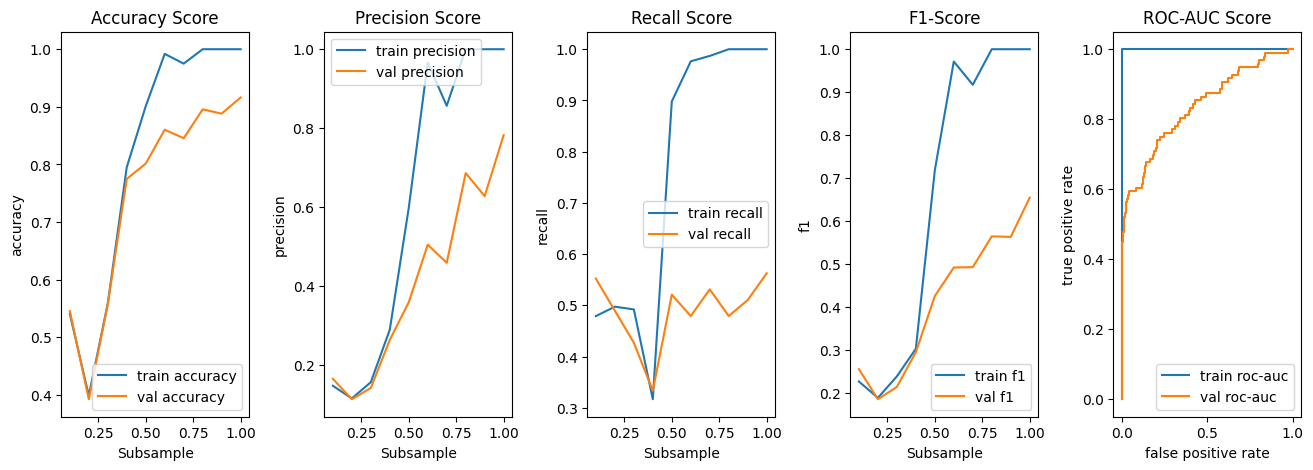

In [267]:
plot_performance(subsample, 'Subsample')

### Reduce Overfitting with Loss Function

default = log_loss

In [268]:
loss = ['log_loss', 'exponential']

In [269]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in loss:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_loss = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=loss)

tune_loss

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
log_loss,1.0,0.916176,1.0,0.782609,1.0,0.5625,1.0,0.654545,1.0,0.836116
exponential,1.0,0.913235,1.0,0.813559,1.0,0.5000,1.0,0.619355,1.0,0.823166


### Reduce Overfitting with Min Samples per Leaf

default = 1

In [270]:
min_samples_leaf = [1, 2, 5, 10, 20, 30, 50, 60, 70, 80, 90,100]

In [271]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,1.0,0.916176,1.0,0.782609,1.0,0.562500,1.0,0.654545,1.0,0.836116
2,1.0,0.917647,1.0,0.812500,1.0,0.541667,1.0,0.650000,1.0,0.829374
5,1.0,0.904412,1.0,0.746032,1.0,0.489583,1.0,0.591195,1.0,0.810484
10,1.0,0.905882,1.0,0.735294,1.0,0.520833,1.0,0.609756,1.0,0.803849
20,1.0,0.901471,1.0,0.716418,1.0,0.500000,1.0,0.588957,1.0,0.810395
30,1.0,0.911765,1.0,0.790323,1.0,0.510417,1.0,0.620253,1.0,0.815158
50,1.0,0.905882,1.0,0.728571,1.0,0.531250,1.0,0.614458,1.0,0.821097
60,1.0,0.889706,1.0,0.640000,1.0,0.500000,1.0,0.561404,1.0,0.784924
70,1.0,0.892647,1.0,0.653333,1.0,0.510417,1.0,0.573099,1.0,0.799479
80,1.0,0.901471,1.0,0.704225,1.0,0.520833,1.0,0.598802,1.0,0.817887


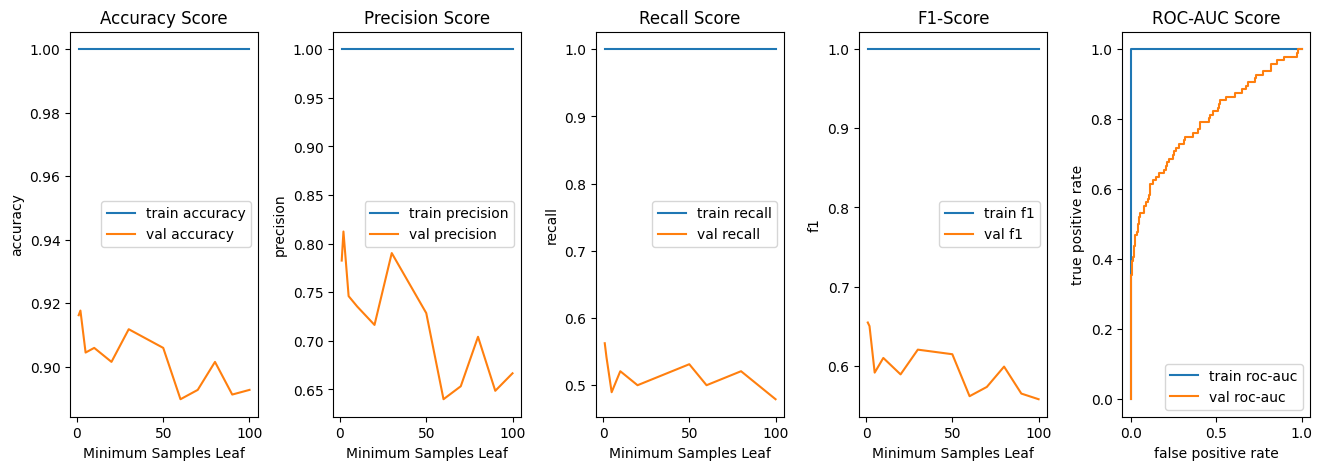

In [272]:
plot_performance(min_samples_leaf, 'Minimum Samples Leaf')

#### min_samples_leaf = 1

In [273]:
gb_min_samples_leaf = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=1)
gb_min_samples_leaf.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_state=8,
                           subsample=1)

                accuracy  precision  recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.0000  1.000000  1.000000
Validation Set  0.916176   0.782609  0.5625  0.654545  0.836116


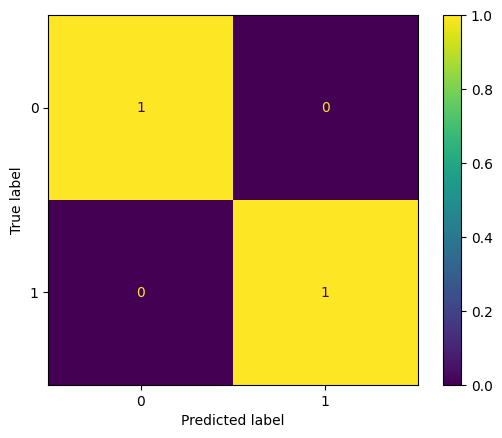

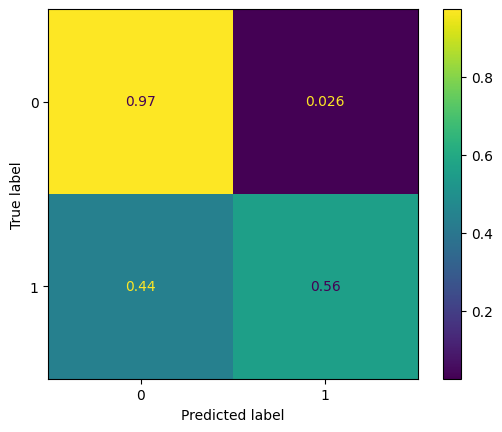

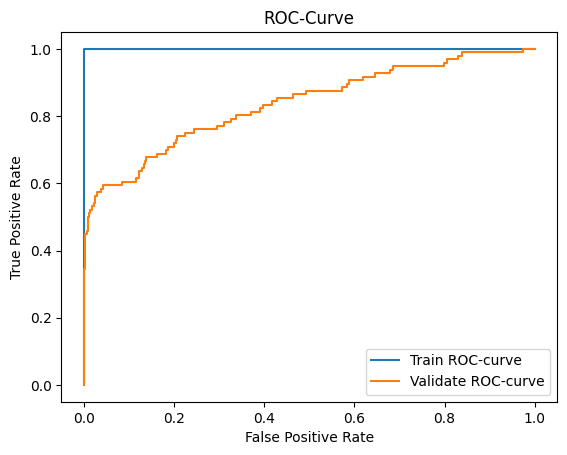

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.916176,0.782609,0.5625,0.654545,0.836116


In [274]:
gradient_boosting(gb_min_samples_leaf)

### Reduce Overfitting with Min Samples Split

default = 2

In [275]:
min_samples_split = [2, 3, 5, 10, 20, 50, 60, 70, 80, 90, 100]

In [276]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=1, min_samples_split=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,1.0,0.916176,1.0,0.782609,1.0,0.562500,1.0,0.654545,1.0,0.836116
3,1.0,0.905882,1.0,0.750000,1.0,0.500000,1.0,0.600000,1.0,0.820152
5,1.0,0.904412,1.0,0.731343,1.0,0.510417,1.0,0.601227,1.0,0.827215
10,1.0,0.910294,1.0,0.769231,1.0,0.520833,1.0,0.621118,1.0,0.821454
20,1.0,0.905882,1.0,0.728571,1.0,0.531250,1.0,0.614458,1.0,0.825664
50,1.0,0.911765,1.0,0.764706,1.0,0.541667,1.0,0.634146,1.0,0.824558
60,1.0,0.910294,1.0,0.739726,1.0,0.562500,1.0,0.639053,1.0,0.826323
70,1.0,0.904412,1.0,0.738462,1.0,0.500000,1.0,0.596273,1.0,0.807577
80,1.0,0.901471,1.0,0.704225,1.0,0.520833,1.0,0.598802,1.0,0.808612
90,1.0,0.904412,1.0,0.738462,1.0,0.500000,1.0,0.596273,1.0,0.825004


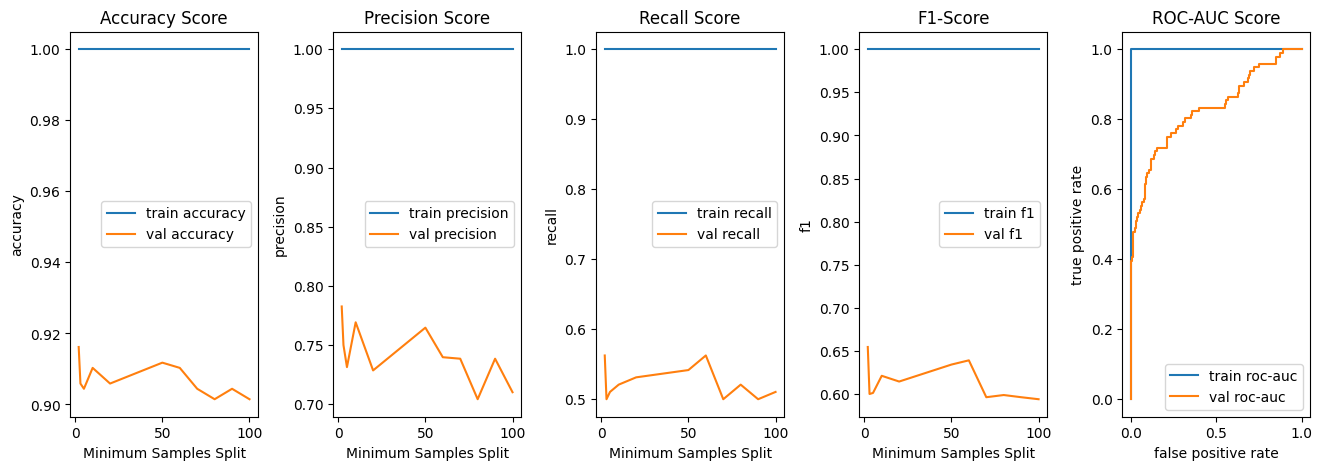

In [277]:
plot_performance(min_samples_split, 'Minimum Samples Split')

#### min_samples_split = 2

In [278]:
gb_min_samples_leaf = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=1, min_samples_split=2)
gb_min_samples_leaf.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_state=8,
                           subsample=1)

                accuracy  precision  recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.0000  1.000000  1.000000
Validation Set  0.916176   0.782609  0.5625  0.654545  0.836116


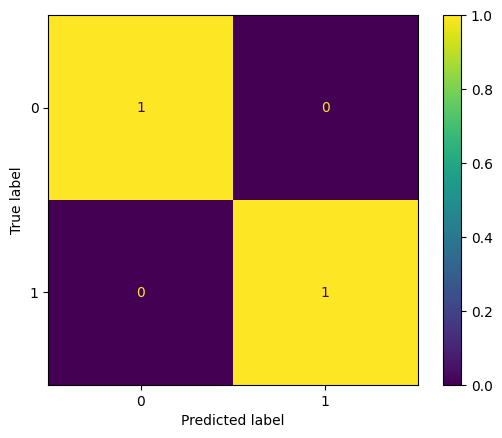

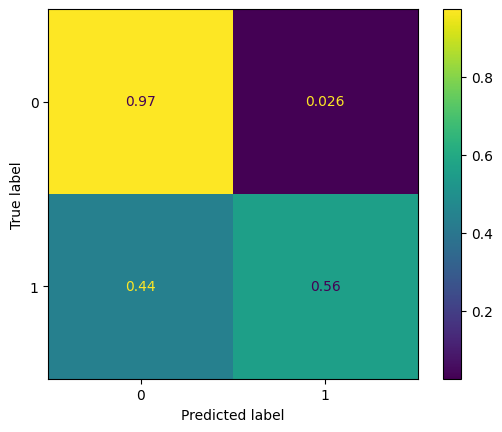

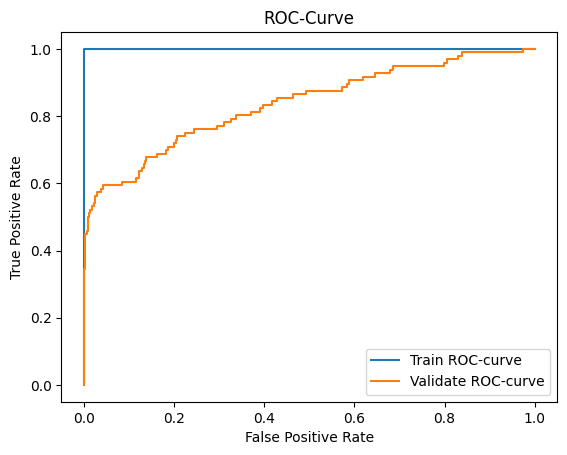

,accuracy,precision,recall,f1-score,roc-auc
Gradient Boosting,0.916176,0.782609,0.5625,0.654545,0.836116


In [279]:
gradient_boosting(gb_min_samples_leaf)

### Reduce overfitting with Max Features

In [280]:
max_features = ['sqrt', 'log2', None]

In [281]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    gb = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=1, min_samples_split=2, max_features=i).fit(X_train, y_train, sample_weight=class_weights)
    y_train_preds = gb.predict(X_train)
    y_val_preds = gb.predict(X_val)
    
    y_train_probs = gb.predict_proba(X_train)[:, 1]
    y_val_probs = gb.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
sqrt,1.0,0.904412,1.0,0.738462,1.0,0.5000,1.0,0.596273,1.0,0.803831
log2,1.0,0.907353,1.0,0.761905,1.0,0.5000,1.0,0.603774,1.0,0.789954
None,1.0,0.916176,1.0,0.782609,1.0,0.5625,1.0,0.654545,1.0,0.836116


### Model After Hyperparameter Tuning

In [282]:
gb_tune = GradientBoostingClassifier(random_state=8, learning_rate=1, n_estimators=500, max_depth=3, subsample=1, loss='log_loss', min_samples_leaf=1, min_samples_split=2, max_features=None)
gb_tune.fit(X_train, y_train, sample_weight=class_weights)

GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_state=8,
                           subsample=1)

                accuracy  precision  recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.0000  1.000000  1.000000
Validation Set  0.916176   0.782609  0.5625  0.654545  0.836116


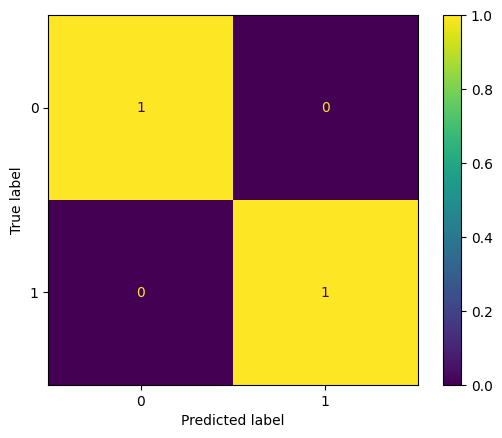

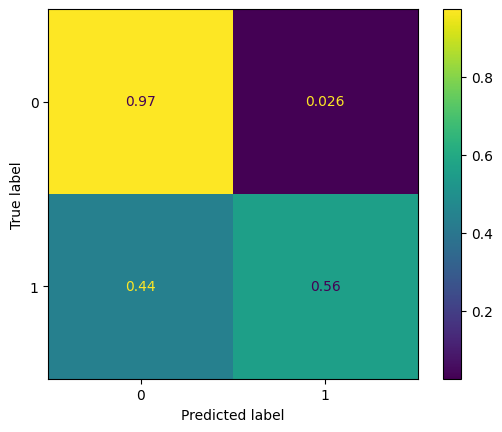

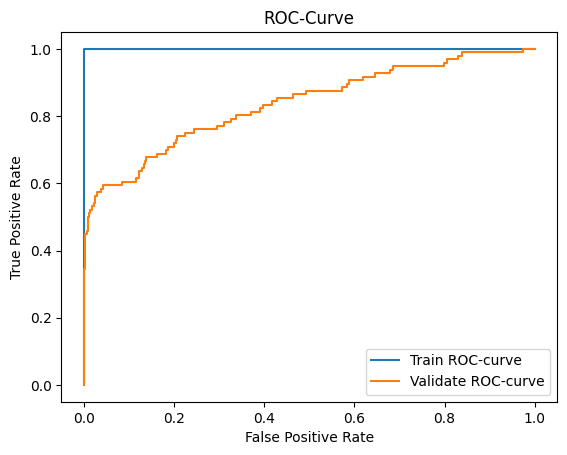

In [283]:
gb = gradient_boosting(gb_tune)

In [284]:
dump(gb, '../models/gradient_boosting.joblib')

['../models/gradient_boosting.joblib']

In [285]:
adjust_threshold(gb_tune)

,accuracy,precision,recall,f1-score,roc-auc
Threshold = 0.1 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.1 - Validation Set,0.901471,0.670588,0.593750,0.629834,0.836116
Threshold = 0.2 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.2 - Validation Set,0.908824,0.717949,0.583333,0.643678,0.836116
Threshold = 0.3 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.3 - Validation Set,0.911765,0.743243,0.572917,0.647059,0.836116
Threshold = 0.4 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.4 - Validation Set,0.914706,0.763889,0.572917,0.654762,0.836116
Threshold = 0.5 - Training Set,1.000000,1.000000,1.000000,1.000000,1.000000
Threshold = 0.5 - Validation Set,0.916176,0.782609,0.562500,0.654545,0.836116


**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [286]:
gb.to_csv('../data/processed/model/5_gb.csv', index=False)